In [1]:
import pandas as pd

from tqdm import tqdm
from xml.etree import ElementTree as ET
from networkx import Graph, DiGraph
import numpy as np
import glasbey
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

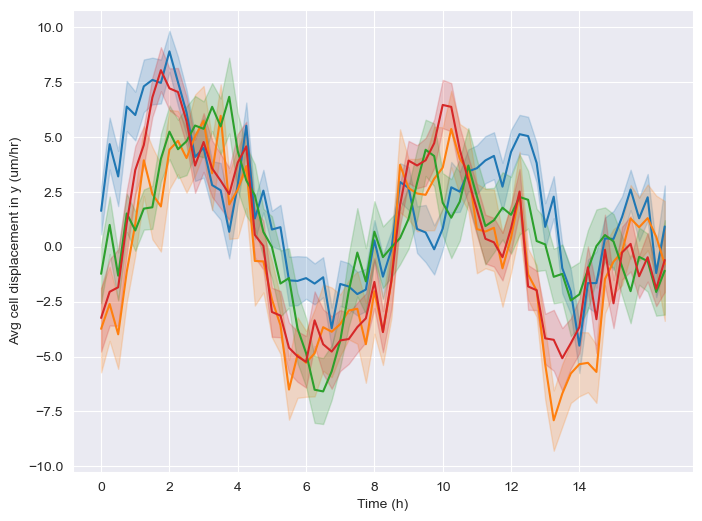

In [56]:
track_path = Path(r"D:\FeedbackControl\data\results\tracks")

import matplotlib as mpl

fig, ax = plt.subplots(1, 1, figsize=(8, 6))


subsets = []
pal = plt.get_cmap("viridis")

for src in list(track_path.iterdir()):
    if not src.name.endswith(".csv"):
        continue

    if src.stem[:6] != "bounce":
        continue

    spots_df = pd.read_csv(src)

    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * 0.66
    spots_df["um_y"] = spots_df["px_y"] * 0.66
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    spots_df["t_hour_q"] = (spots_df["t"] // 15) / 4

    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    barstr = src.stem.split(".")[0][6:]

    period = int(barstr)

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5
        spots_df[f"{col}_per_hour"] = spots_df[f"{col}_per_min"] * 60

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)
    spots_df["avg_speed"] = spots_df["track_id"].map(spots_df.groupby("track_id")["um_speed"].mean())
    spots_df["track_length"] = spots_df["track_id"].map(spots_df.groupby("track_id")["um_speed"].count())

    bar_speed = 0.5
    period_time = 100 / bar_speed
    duty_cycle = 0.2
    t_loop_m = period

    t = spots_df["t"]
    t = t % t_loop_m

    halfway = t_loop_m / 2

    t = ((halfway - (t - halfway)) * (t > halfway)) + (t * (t <= halfway))  # inline conditional

    spots_df["t_loop_m"] = t

    spots_df["phase"] = (((spots_df["t_loop_m"] - (spots_df["um_y"] / bar_speed)) % period_time) / period_time) - 0.1
    spots_df["phase"] = (spots_df["phase"] * (spots_df["phase"] < 0.5)) + ((-1 + spots_df["phase"]) * (spots_df["phase"] >= 0.5))
    spots_df["phase_coarse"] = ((spots_df["phase"] + 0.1) // 0.2) * 0.2

    x_lo, x_hi = spots_df["um_x"].quantile([.25, .75])
    y_lo, y_hi = spots_df["um_y"].quantile([.25, .75])

    subset = spots_df[
        spots_df["um_x"].between(x_lo, x_hi) &
        spots_df["um_y"].between(y_lo, y_hi) &
        (spots_df["avg_speed"] > spots_df["avg_speed"].quantile(0.75)) &
        (spots_df["track_length"] > 10)
    ].copy()


    sns.lineplot(data=subset, x="t_hour_q", y="um_y_per_hour", errorbar=("ci", 95),
                 estimator="mean", ax=ax)

    subset["dset"] = src.stem
    subset["track_id"] = subset["dset"] + subset["track_id"].astype(str)

    subsets.append(subset)


all_data = pd.concat(subsets, ignore_index=True)

cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)


ax.set_ylabel("Avg cell displacement in y (um/hr)")
ax.set_xlabel("Time (h)")

ax.set_xticks(list(range(0, 16, 2)))

plt.savefig(r"D:\FeedbackControl\data\results\barbounce.png", dpi=150)
plt.show()


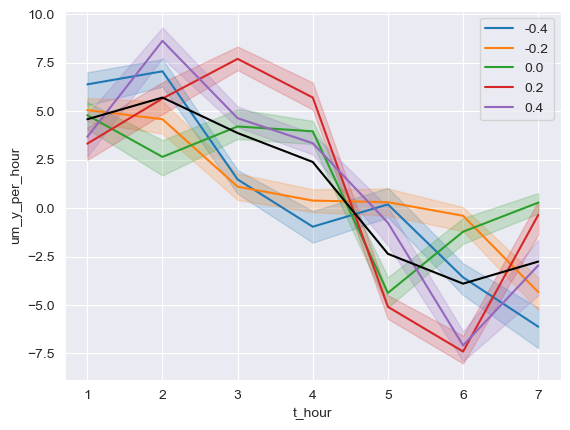

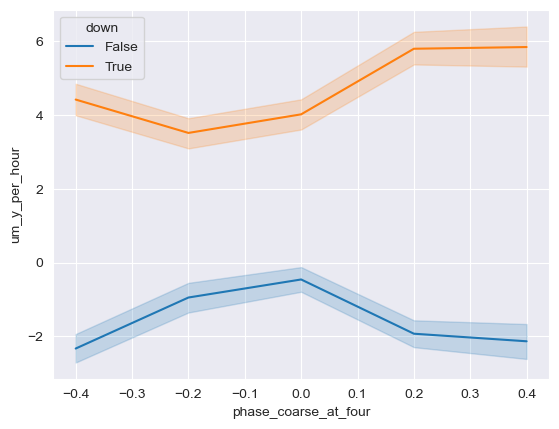

In [61]:
short = all_data[all_data["t_hour"].between(1, 7)].copy()

phase = short[short["t_hour"].between(3.75, 4.25)].groupby("track_id")["phase"].median()
short["phase_at_four"] = short["track_id"].map(phase)
short["phase_fine_at_four"] = ((short["phase_at_four"] + 0.025) // 0.05) * 0.05
short["phase_coarse_at_four"] = ((short["phase_at_four"] + 0.1) // 0.2) * 0.2

short["phase_fine"] = ( short["phase"] // 0.05 ) * 0.05
short["down"] = short["t_hour"] < 4

sns.lineplot(short, x = "t_hour", y = "um_y_per_hour", hue = "phase_coarse_at_four", errorbar = ("ci", 95), palette="tab10", estimator="median")
sns.lineplot(short, x = "t_hour", y = "um_y_per_hour", color="k", errorbar=None, linewidth=1.5)
plt.show()

sns.lineplot(short, x = "phase_coarse_at_four", y = "um_y_per_hour", hue="down")
plt.show()

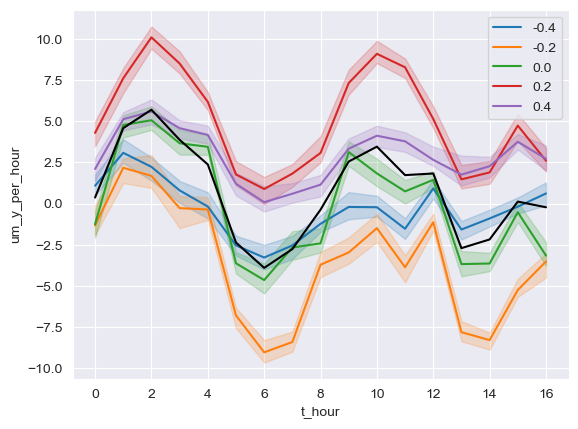

In [68]:
short = all_data.copy()

phase = short[short["t_hour"].between(7.75, 8.25)].groupby("track_id")["phase"].median()
short["phase_at_four"] = short["track_id"].map(phase)
short["phase_fine_at_four"] = (short["phase_at_four"] // 0.05) * 0.05
short["phase_coarse_at_four"] = ((short["phase_at_four"] + 0.1) // 0.2) * 0.2

short["phase_fine"] = ( short["phase"] // 0.05 ) * 0.05
short["down"] = short["t_hour"] < 4

sns.lineplot(short, x = "t_hour", y = "um_y_per_hour", hue = "phase_coarse", errorbar = ("ci", 95), palette="tab10", estimator="median")
sns.lineplot(short, x = "t_hour", y = "um_y_per_hour", color="k", errorbar=None, linewidth=1.5)
plt.show()

# sns.lineplot(short, x = "phase_fine_at_four", y = "um_y_per_hour", hue="down")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

for ss in subsets:

    sss = ss[ss["track_id"].isin(ss["track_id"].sample(3))]

    for tid, group in sss.groupby("track_id"):

        y_avg = group["um_y_per_min"].rolling(10).mean()

        plt.plot(group["t"]/60, y_avg)


plt.show()